In [451]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import glob
from IPython.display import display
from functools import reduce
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

In [217]:
def adf_test(series,title=''):
    """
    Pass in a time series and an optional title, returns an ADF report
    """
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(),autolag='AIC') # .dropna() handles differenced data
    labels = ['ADF test statistic','p-value','# lags used','# observations']
    out = pd.Series(result[0:4],index=labels)
    for key,val in result[4].items():
        out[f'critical value ({key})']=val
    print(out.to_string())          # .to_string() removes the line "dtype: float64"
    if result[1] <= 0.05:
        print("Strong evidence against the null hypothesis")
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
    else:
        print("Weak evidence against the null hypothesis")
        print("Fail to reject the null hypothesis")
        print("Data has a unit root and is non-stationary")

In [327]:
def get_data(city_name):
    city_housing_demand = pd.read_csv(f"../demand_influx_data/new_private_housing_permits_{city_name}.csv")
    city_personal_income = pd.read_csv(f"../economic_data/personal_income_{city_name}.csv")
    city_population = pd.read_csv(f"../demand_influx_data/resident_population_{city_name}.csv")
    city_housing_price = pd.read_csv(f"../economic_data/housing_price_index_{city_name}.csv")
    city_unemployment_data = pd.read_csv(f"../economic_data/unemployment_{city_name}.csv")
    city_target_data = pd.read_csv(f"../target_data/construction_target_{city_name}.csv")

    city_target_data = city_target_data.rename(columns={city_target_data.columns[1] : "target"})
    city_housing_demand = city_housing_demand.rename(columns={city_housing_demand.columns[1] : "city_housing"})
    city_personal_income = city_personal_income.rename(columns={city_personal_income.columns[1] : "personal_income"})
    city_housing_price = city_housing_price.rename(columns={city_housing_price.columns[1] : "housing_price"})
    city_unemployment_data = city_unemployment_data.rename(columns={city_unemployment_data.columns[1] : "unemployment"})
    city_population = city_population.rename(columns={city_population.columns[1] : "population"})

  #  for df in [city_housing_demand, city_personal_income, city_population, city_housing_price, city_unemployment_data, city_target_data]:
  #      df['year'] = pd.DatetimeIndex(df['DATE']).year
  #      df['month'] = pd.DatetimeIndex(df['DATE']).month
        
    df = reduce(lambda left,right: pd.merge(left,right,on=['DATE'],
                                            how='outer'), [city_housing_demand, city_housing_price, city_unemployment_data, city_target_data])
        
    print(adf_test(city_target_data["target"]))

    df['year'] = pd.DatetimeIndex(df['DATE']).year
    df['month'] = pd.DatetimeIndex(df['DATE']).month

    df = df[(df['year'] > 2000)]

    df["housing_price"].fillna(df["housing_price"].median(), inplace=True)

    display(df)

    return df[["city_housing", "housing_price", "unemployment", "target"]].values

In [490]:
def fit_city(city_name, years_ahead=51):
    data = get_data(city_name)
    model = VAR(data)
    results = model.fit(15)

    pred = results.forecast_interval(y=data[-15:, :], steps=12*years_ahead) 
    pred_lower_bound = pred[0][:,-1] * 1000
    pred_upper_bound = pred[1][:,-1] * 1000
    pred = ((pred_lower_bound + pred_upper_bound) / 2)

    yearly_sums = []
    prev_sums = []
    yearly_lower_bound_sums = []
    yearly_upper_bound_sums = []

    for year in range(0, 12):
        prev_sums.append(sum(data[(11 + year) * 12:((11 + year)+1) * 12, -1]))
        prev_sums[year] = prev_sums[year] * 1000

    for year in range(years_ahead-1):
        yearly_sums.append(sum(pred[year * 12:(year+1) * 12]))

    for year in range(years_ahead-1):
        yearly_lower_bound_sums.append(sum(pred_lower_bound[year * 12:(year+1) * 12]))

    for year in range(years_ahead-1):
        yearly_upper_bound_sums.append(sum(pred_upper_bound[year * 12:(year+1) * 12]))

    return yearly_sums, prev_sums, yearly_lower_bound_sums, yearly_upper_bound_sums

In [491]:
a, b, c, d = fit_city("seattle")

house_built = pd.read_csv("../target_data/new_houses_each_year.csv")

seattle_y = house_built["Seattle"].values
alberquerque_y = house_built["Alberquerque"].values

poly = PolynomialFeatures(degree=1, include_bias=True)

poly_features = poly.fit_transform(np.array(b).reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, seattle_y)

seattle_house_lower = poly_reg_model.predict(poly.transform(np.array(c).reshape(-1, 1)))
seattle_house_upper = poly_reg_model.predict(poly.transform(np.array(d).reshape(-1, 1)))

seattle_house_change = poly_reg_model.predict(poly.transform(np.array(a).reshape(-1, 1)))

a, b, c, d = fit_city("albuquerque")

poly = PolynomialFeatures(degree=1, include_bias=True)

poly_features = poly.fit_transform(np.array(b).reshape(-1, 1))
poly_reg_model = LinearRegression()
poly_reg_model.fit(poly_features, alberquerque_y)

alberquerque_house_lower = poly_reg_model.predict(poly.transform(np.array(c).reshape(-1, 1)))
alberquerque_house_upper = poly_reg_model.predict(poly.transform(np.array(d).reshape(-1, 1)))

albuquerque_house_change = poly_reg_model.predict(poly.transform(np.array(a).reshape(-1, 1)))

Augmented Dickey-Fuller Test: 
ADF test statistic       -1.932006
p-value                   0.317157
# lags used              18.000000
# observations          389.000000
critical value (1%)      -3.447273
critical value (5%)      -2.868999
critical value (10%)     -2.570743
Weak evidence against the null hypothesis
Fail to reject the null hypothesis
Data has a unit root and is non-stationary
None


,DATE,city_housing,housing_price,unemployment,target,year,month
156,2001-01-01,2489.007676,149.26,4.4,99.3,2001,1
157,2001-02-01,1670.862728,240.29,4.5,98.4,2001,2
158,2001-03-01,2110.581917,240.29,4.6,99.7,2001,3
159,2001-04-01,1982.937459,151.80,4.7,98.5,2001,4
160,2001-05-01,1878.117265,240.29,4.8,100.3,2001,5
...,...,...,...,...,...,...,...
427,2023-08-01,1595.905943,240.29,3.4,142.7,2023,8
428,2023-09-01,1155.826444,240.29,3.5,139.8,2023,9
429,2023-10-01,1562.174231,502.16,3.6,137.6,2023,10
430,2023-11-01,1068.583250,240.29,3.8,134.9,2023,11


Augmented Dickey-Fuller Test: 
ADF test statistic       -3.556589
p-value                   0.006647
# lags used              12.000000
# observations          395.000000
critical value (1%)      -3.447014
critical value (5%)      -2.868885
critical value (10%)     -2.570683
Strong evidence against the null hypothesis
Reject the null hypothesis
Data has no unit root and is stationary
None


,DATE,city_housing,housing_price,unemployment,target,year,month
156,2001-01-01,197.0,113.03,4.1,24.5,2001,1
157,2001-02-01,402.0,162.17,4.1,24.5,2001,2
158,2001-03-01,687.0,162.17,4.1,24.8,2001,3
159,2001-04-01,578.0,113.97,4.1,25.0,2001,4
160,2001-05-01,503.0,162.17,4.1,25.3,2001,5
...,...,...,...,...,...,...,...
427,2023-08-01,235.0,162.17,3.6,27.4,2023,8
428,2023-09-01,184.0,162.17,3.6,27.6,2023,9
429,2023-10-01,160.0,283.57,3.7,28.7,2023,10
430,2023-11-01,210.0,162.17,3.8,28.8,2023,11


In [492]:
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})
sns.set(font_scale=1.5)

In [497]:
housing_units_seattle = [372436]
housing_units_albuquerque = [255178]
housing_units_seattle_lower = [372436]
housing_units_albuquerque_lower = [255178]
housing_units_seattle_higher = [372436]
housing_units_albuquerque_higher = [255178]

for i in range(len(seattle_house_change)):
    housing_units_seattle.append(seattle_house_change[i] + housing_units_seattle[i])

for i in range(len(albuquerque_house_change)):
    housing_units_albuquerque.append(albuquerque_house_change[i] + housing_units_albuquerque[i])

for i in range(len(seattle_house_change)):
    housing_units_seattle_lower.append(seattle_house_lower[i] + housing_units_seattle_lower[i])

for i in range(len(albuquerque_house_change)):
    housing_units_albuquerque_lower.append(alberquerque_house_lower[i] + housing_units_albuquerque_lower[i])

for i in range(len(seattle_house_change)):
    housing_units_seattle_higher.append(seattle_house_upper[i] + housing_units_seattle_higher[i])

for i in range(len(albuquerque_house_change)):
    housing_units_albuquerque_higher.append(alberquerque_house_upper[i] + housing_units_albuquerque_higher[i])

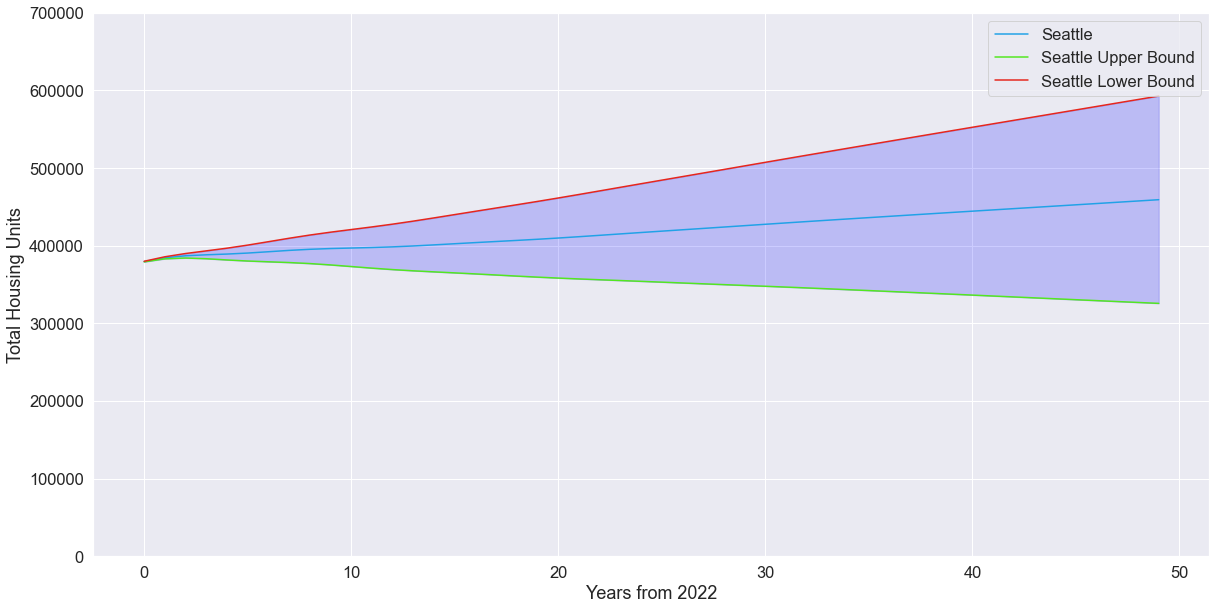

In [511]:
s_data = pd.DataFrame({
    "Years from 2022" : range(50),
    "Total Housing Units" : housing_units_seattle[1:],
})

s_h_data = pd.DataFrame({
    "Years from 2022" : range(50),
    "Total Housing Units" : housing_units_seattle_higher[1:],
})

s_l_data = pd.DataFrame({
    "Years from 2022" : range(50),
    "Total Housing Units" : housing_units_seattle_lower[1:],
})

a_data = pd.DataFrame({
    "Years from 2022" : range(50),
    "Total Housing Units" : housing_units_albuquerque[1:],
})

a_l_data = pd.DataFrame({
    "Years from 2022" : range(50),
    "Total Housing Units" : housing_units_albuquerque_higher[1:],
})

a_h_data = pd.DataFrame({
    "Years from 2022" : range(50),
    "Total Housing Units" : housing_units_albuquerque_lower[1:],
})

plt.figure(figsize=(20, 10))

a = sns.lineplot(data=s_data, x="Years from 2022", y="Total Housing Units", label="Seattle", color="#20A2E7")
b = sns.lineplot(data=s_h_data, x="Years from 2022", y="Total Housing Units", label="Seattle Upper Bound", color="#53E720")
c = sns.lineplot(data=s_l_data, x="Years from 2022", y="Total Housing Units", label="Seattle Lower Bound", color="#E6261C")

line = c.get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='blue', alpha=.2)

plt.ylim(0, 700000)

plt.legend()

plt.show()


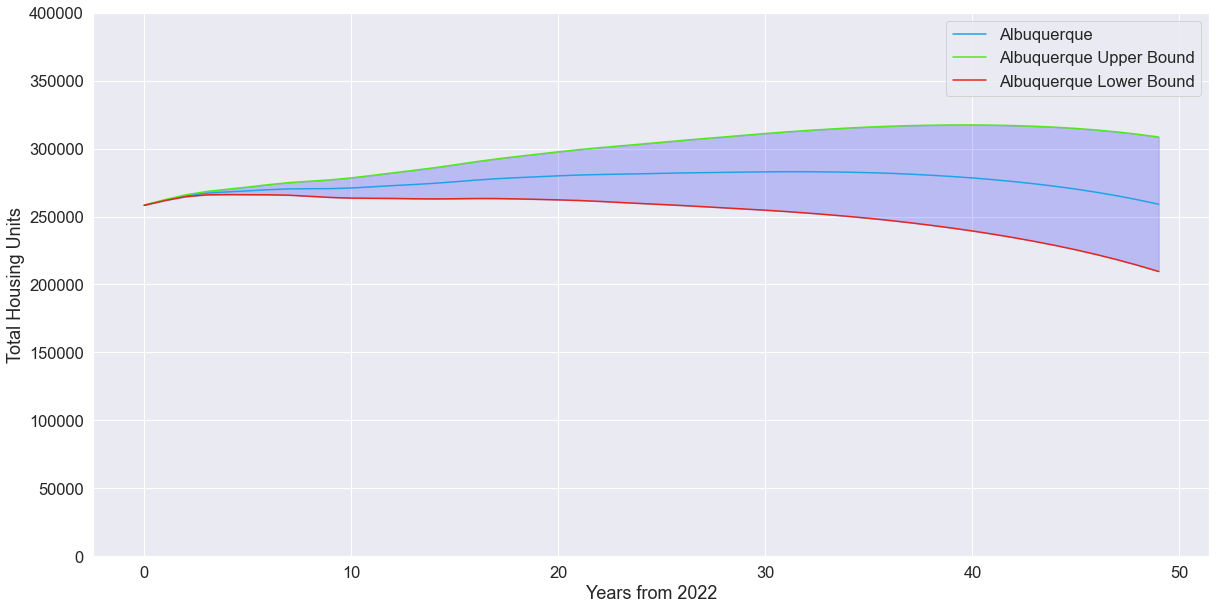

In [513]:
plt.figure(figsize=(20, 10))

a = sns.lineplot(data=a_data, x="Years from 2022", y="Total Housing Units", label="Albuquerque", color="#20A2E7")
b = sns.lineplot(data=a_h_data, x="Years from 2022", y="Total Housing Units", label="Albuquerque Upper Bound", color="#53E720")
c = sns.lineplot(data=a_l_data, x="Years from 2022", y="Total Housing Units", label="Albuquerque Lower Bound", color="#E6261C")

line = c.get_lines()
plt.fill_between(line[0].get_xdata(), line[1].get_ydata(), line[2].get_ydata(), color='blue', alpha=.2)

plt.ylim(0, 400000)

plt.legend()

plt.show()

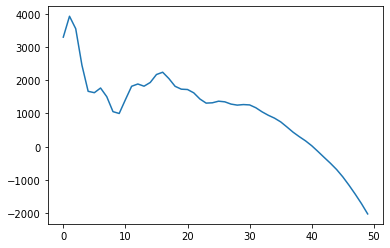

In [441]:
plt.plot(range(50), albuquerque_house_change)